<a href="https://colab.research.google.com/github/asrenninger/urbansim/blob/main/miscellany/abc.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

![](https://github.com/asrenninger/urbansim/blob/main/images/schelling.png?raw=true)

# Schelling's Segregation Model: How Individual Choices Lead to Collective Patterns

Thomas Schelling's [segregation model](https://www.tandfonline.com/doi/abs/10.1080/0022250X.1971.9989794) (1971) is one of the most influential agent-based models in social science, demonstrating how individual preferences can lead to unexpected collective outcomes. The model shows how a mild preference for having some similar neighbors can lead to significant segregation at the community level—even when no individual actively seeks to live in a segregated neighborhood.

## The Key Insight
The model's power lies in its simplicity: Agents of two different groups live on a grid and have a simple preference - they want some portion of their neighbors to be similar to themselves. If this threshold isn't met, they move to a random empty location. Surprisingly, even when agents are quite tolerant (happy with 40% or more of their neighbors being different), the resulting patterns show significant segregation.

## Why Agent-Based Modeling?

![](https://github.com/asrenninger/urbansim/blob/main/images/flock.gif?raw=true)

Traditional mathematical approaches like differential equations excel at modeling aggregate behavior but can struggle to capture emergent phenomena that arise from individual interactions. Agent-Based Models (ABMs) offer several unique advantages:
- **Bottom-up approach**: Instead of describing system-level behavior directly, ABMs let patterns emerge from individual actions
- **Heterogeneity**: Agents can have different characteristics and behaviors, unlike equation-based models that often assume homogeneous populations
- **Local interactions**: ABMs can explicitly model how agents interact with their neighbors and environment
- **Path dependence**: The history of interactions matters, allowing for more realistic modeling of social phenomena

## Why It Matters
This model helps explain how segregation can emerge even without explicit racism or discriminatory policies. It demonstrates that:
- Micro-motives (individual preferences) can lead to macro-behaviors (segregation) that no individual necessarily intended
- Small individual biases can amplify into large collective effects
- Segregation patterns can emerge even in communities where people actively value diversity

The model has influenced fields from sociology and economics to physics and computer science, showing how simple rules can generate complex social patterns.

In [49]:
import numpy as np

import matplotlib.pyplot as plt

# Understanding the Code Structure: An Object-Oriented Implementation

The Schelling model is implemented as a Python class called `abm`, using object-oriented programming (OOP) principles. This design choice helps organize our simulation by bundling together the model's data (attributes) and behaviors (methods) in a coherent way.

## Class Structure and State Management

### The `self` Reference
In Python classes, `self` refers to the specific instance of the model we're working with. When we create a model using `model = abm()`, all attributes and methods will use `self` to keep track of that particular model's state. Think of it as the model's "memory" - it maintains information about:
- The physical space (`self.grid`)
- The agents' properties (`self.agent_feature`, `self.agent_location`)
- The simulation parameters (`self.τ`, `self.density`, etc.)

### Key Attributes (Model State)
```python
self.grid               # the physical grid where agents live (numpy array)
self.agent_feature      # dictionary mapping agent IDs to their group/feature
self.agent_location     # dictionary mapping agent IDs to their coordinates
self.list_feature_grid  # history of grid states throughout simulation
self.list_mix           # history of mixing/segregation metrics
```

### Key Methods (Model Behavior)

```python
initialize()            # sets up initial random state
get_agent_neighbors()   # finds neighbors for a given agent
agents_move()           # handles agent movement decisions
run()
```

### Information Flow

1. Initialization: Parameters flow into the constructor (__init__), setting up the basic model structure
2. State Updates: Methods read the current state through self, make decisions, and update the state
3. History Tracking: Changes are recorded in list_feature_grid and list_mix for later analysis
4. Feedback Loop: The run() method orchestrates this process until equilibrium or timeout

### This OOP structure makes it easy to:

+ Create multiple independent simulations
+ Modify parameters without changing behavior
+ Track the model's evolution over time
+ Add new features or measurements without disrupting existing code

In [50]:
class abm:
    def __init__(self,
                 # lenght of square grid
                 length_grid = None,
                 # fraction of spots with agents
                 density = None,
                 # posible values of the feature
                 n_features = None,
                 # tolerance threshold for diversit
                 τ = None,
                 # Other parameters that follow
                 size_grid = None,
                 # number of agents
                 n_agents = None,
                 # agent ids
                 agents = None,
                 # grid with agent position
                 grid = None,
                 # dictionaries with agent features
                 agent_feature = None,
                 # dictionaries with agent location
                 agent_location = None,
                 # list with feature grids
                 list_feature_grid = None,
                 # list with mix index
                 list_mix = None,
                 # seed
                 seed = None
                 ):

        # set seed
        self.seed = seed if seed is not None else 123
        np.random.seed(seed)


        # set dimensions and parameters
        self.length_grid = length_grid if length_grid is not None else 100
        self.density = density if density is not None else 0.9
        self.n_features = n_features if n_features is not None else 2
        self.τ = τ if τ is not None else 0.6

        # set other variables that follow
        # grid size
        self.size_grid = size_grid if size_grid is not None else int(self.length_grid * self.length_grid)
        # number of agents
        self.n_agents = n_agents if n_agents is not None else int(self.size_grid*self.density)
        # defining agents in the model
        # each agent will be identified with an id (unique number)
        self.agents = agents if agents is not None \
            else [i for i in range(self.n_agents)]
        # set an initial variable for grid to be set properly in initiliazation
        self.grid = grid if grid is not None else np.arange(0, self.size_grid, dtype=float)

        # dictionaries with agent features and locations
        self.agent_feature = agent_feature if agent_feature is not None else {}
        self.agent_location = agent_location if agent_location is not None else {}
        self.list_feature_grid = list_feature_grid if list_feature_grid is not None else []
        self.list_mix = list_mix if list_mix is not None else []


    def initialize(self):
        '''
        Initializes agents location in grid and their features
        '''
        # build grid
        empty_locations = self.size_grid - self.n_agents
        # fill grid with agents
        # grid = np.arange(0, size_grid, dtype=float)
        # for last rows put nan numbers (empty ones)
        self.grid[self.n_agents:] = np.nan * np.ones(empty_locations)
        # shuffle agents and nan's
        np.random.shuffle(self.grid)
        # reshape to get grid
        self.grid = self.grid.reshape(self.length_grid, self.length_grid)

        # set agent features and location
        for agent_id in range(self.n_agents):
            self.agent_feature[agent_id] = np.random.choice(self.n_features)
            self.agent_location[agent_id] = np.argwhere(self.grid == int(agent_id))[0]

    def make_feature_grid(self):
        '''
        Takes grid and feature of agents to show seggregation map
        '''
        #initiliaize grid, by default zeros (empty spaces)
        feature_grid = np.zeros([self.length_grid, self.length_grid])

        for i in range(self.length_grid):
            for j in range(self.length_grid):
                # get agent number
                agent_id = self.grid[i, j]
                # if there is an agent, then modify to -1 or 1 depending on feature
                if np.isnan(agent_id) == False:
                    if self.agent_feature[agent_id] == 0:
                        feature_grid[i, j] = -1
                    else:
                        feature_grid[i, j] = +1

        return feature_grid

    def get_agent_neighbors(self, agent_id):
        '''
        Args:
            agent_id(int): unique identifier of agent
            agent_location(dict): given a location returns id of agent on it
            grid(np array): 2d array, give x-y coordinates gives id of agent there or nan if empty
            size_grid(int): size of the grid used for coners
        Return:
            neighbors(list): list of neighbors of id
        '''
        x, y = self.agent_location[agent_id]

        neighbors = []
        for i in range(-1, 2):
            for j in range(-1, 2):
                # exclude agent itself
                if i != 0 or j != 0:
                    # take care of corners and sides
                    if x + i < 0 or x + i >= self.length_grid:
                        pass
                    elif y + j < 0 or y + j >= self.length_grid:
                        pass
                    else:
                        # get agetn id from location_agent dict
                        neighbors.append(self.grid[x + i, y + j])

        return neighbors

    def get_agent_neighbors_similarity(self, agent_id):
        '''
        Given an agent calculates the ratio of neighbors that have similar features
        '''

        feature = self.agent_feature[agent_id]
        # set counter of different neighbors
        different_neighbors = 0
        # count number of different neighbots
        neighbors = self.get_agent_neighbors(agent_id)
        n_neighbors = 0

        for neigh in neighbors:
            if np.isnan(neigh) == False:
                # exclude empty spots from denominator
                n_neighbors += 1
                # count different neighbors
                if self.agent_feature[neigh] != self.agent_feature[agent_id]:
                    different_neighbors += 1
        if n_neighbors > 0:
            ratio_difference = different_neighbors/n_neighbors
        else:
            ratio_difference = 1

        return ratio_difference

    def agents_move(self):
        '''
        Iterates through list of all agents and moves then when needed.
        Also returns a number stating the population average mix
        '''
        import random
        # variable to record mix of population
        mix_average = 0
        # Note this is sequatial on agents ids, not location
        for agent_id in self.agents:
            # calcualte differences
            ratio_difference = self.get_agent_neighbors_similarity(agent_id)
            mix_average += ratio_difference

            # move agents if needed
            if ratio_difference > self.τ:
                # get their previous location
                x_old, y_old = self.agent_location[agent_id]
                # choose new location
                empty_spaces = list(np.argwhere(np.isnan(self.grid)))
                x_new, y_new = random.choice(empty_spaces)

                # update locations
                self.grid[(x_new, y_new)] = agent_id
                self.grid[(x_old, y_old)] = np.nan
                self.agent_location[agent_id] = (x_new, y_new)

        mix_average = mix_average/len(self.agents)
        return mix_average

    def all_agents_happy(self):
        '''
        Calcualtes whether all agents are happy with their current location
        '''
        all_happy = True
        # Note this is sequatial on agents ids, not location
        for agent_id in self.agents:
            # calcualte differences
            ratio_difference = self.get_agent_neighbors_similarity(agent_id)

            # move agents if needed
            if ratio_difference > self.τ:
                all_happy = False

        return all_happy

    def run(self):
        # calculate initial mix
        initial_mix = 0
        for agent_id in self.agents:
            # calcualte differences
            ratio_difference = self.get_agent_neighbors_similarity(agent_id)
            initial_mix += ratio_difference

        initial_mix = initial_mix/len(self.agents)
        # add initial state to lists
        self.list_mix.append(initial_mix)
        self.list_feature_grid.append(self.make_feature_grid())

        counter_safety = 0
        # while not all agents are happy move
        while  self.all_agents_happy() == False:
            # calculate mix
            mt = self.agents_move()
            # append mix and feature matrix to lists
            self.list_mix.append(mt)
            self.list_feature_grid.append(self.make_feature_grid())


            # for safety
            counter_safety += 1
            if counter_safety > 1000:
                print("break time exceeded")
                break

In [51]:
# an agent looks at their neighbors
# if they have 8 neighbors and 6 are different (75% different > τ of 60%)
# they will move to a random empty spot
# this continues until everyone is "happy" with their local neighborhood

In [52]:
# choose a tolerance
tau = 0.6
# choose a grid size
Schellings_abm = abm(τ=tau, length_grid=100)
# populate the grid
Schellings_abm.initialize()

In [53]:
Schellings_abm.run()

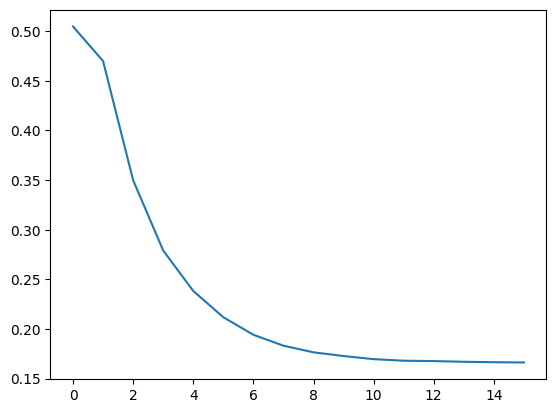

In [59]:
plt.plot(Schellings_abm.list_mix)

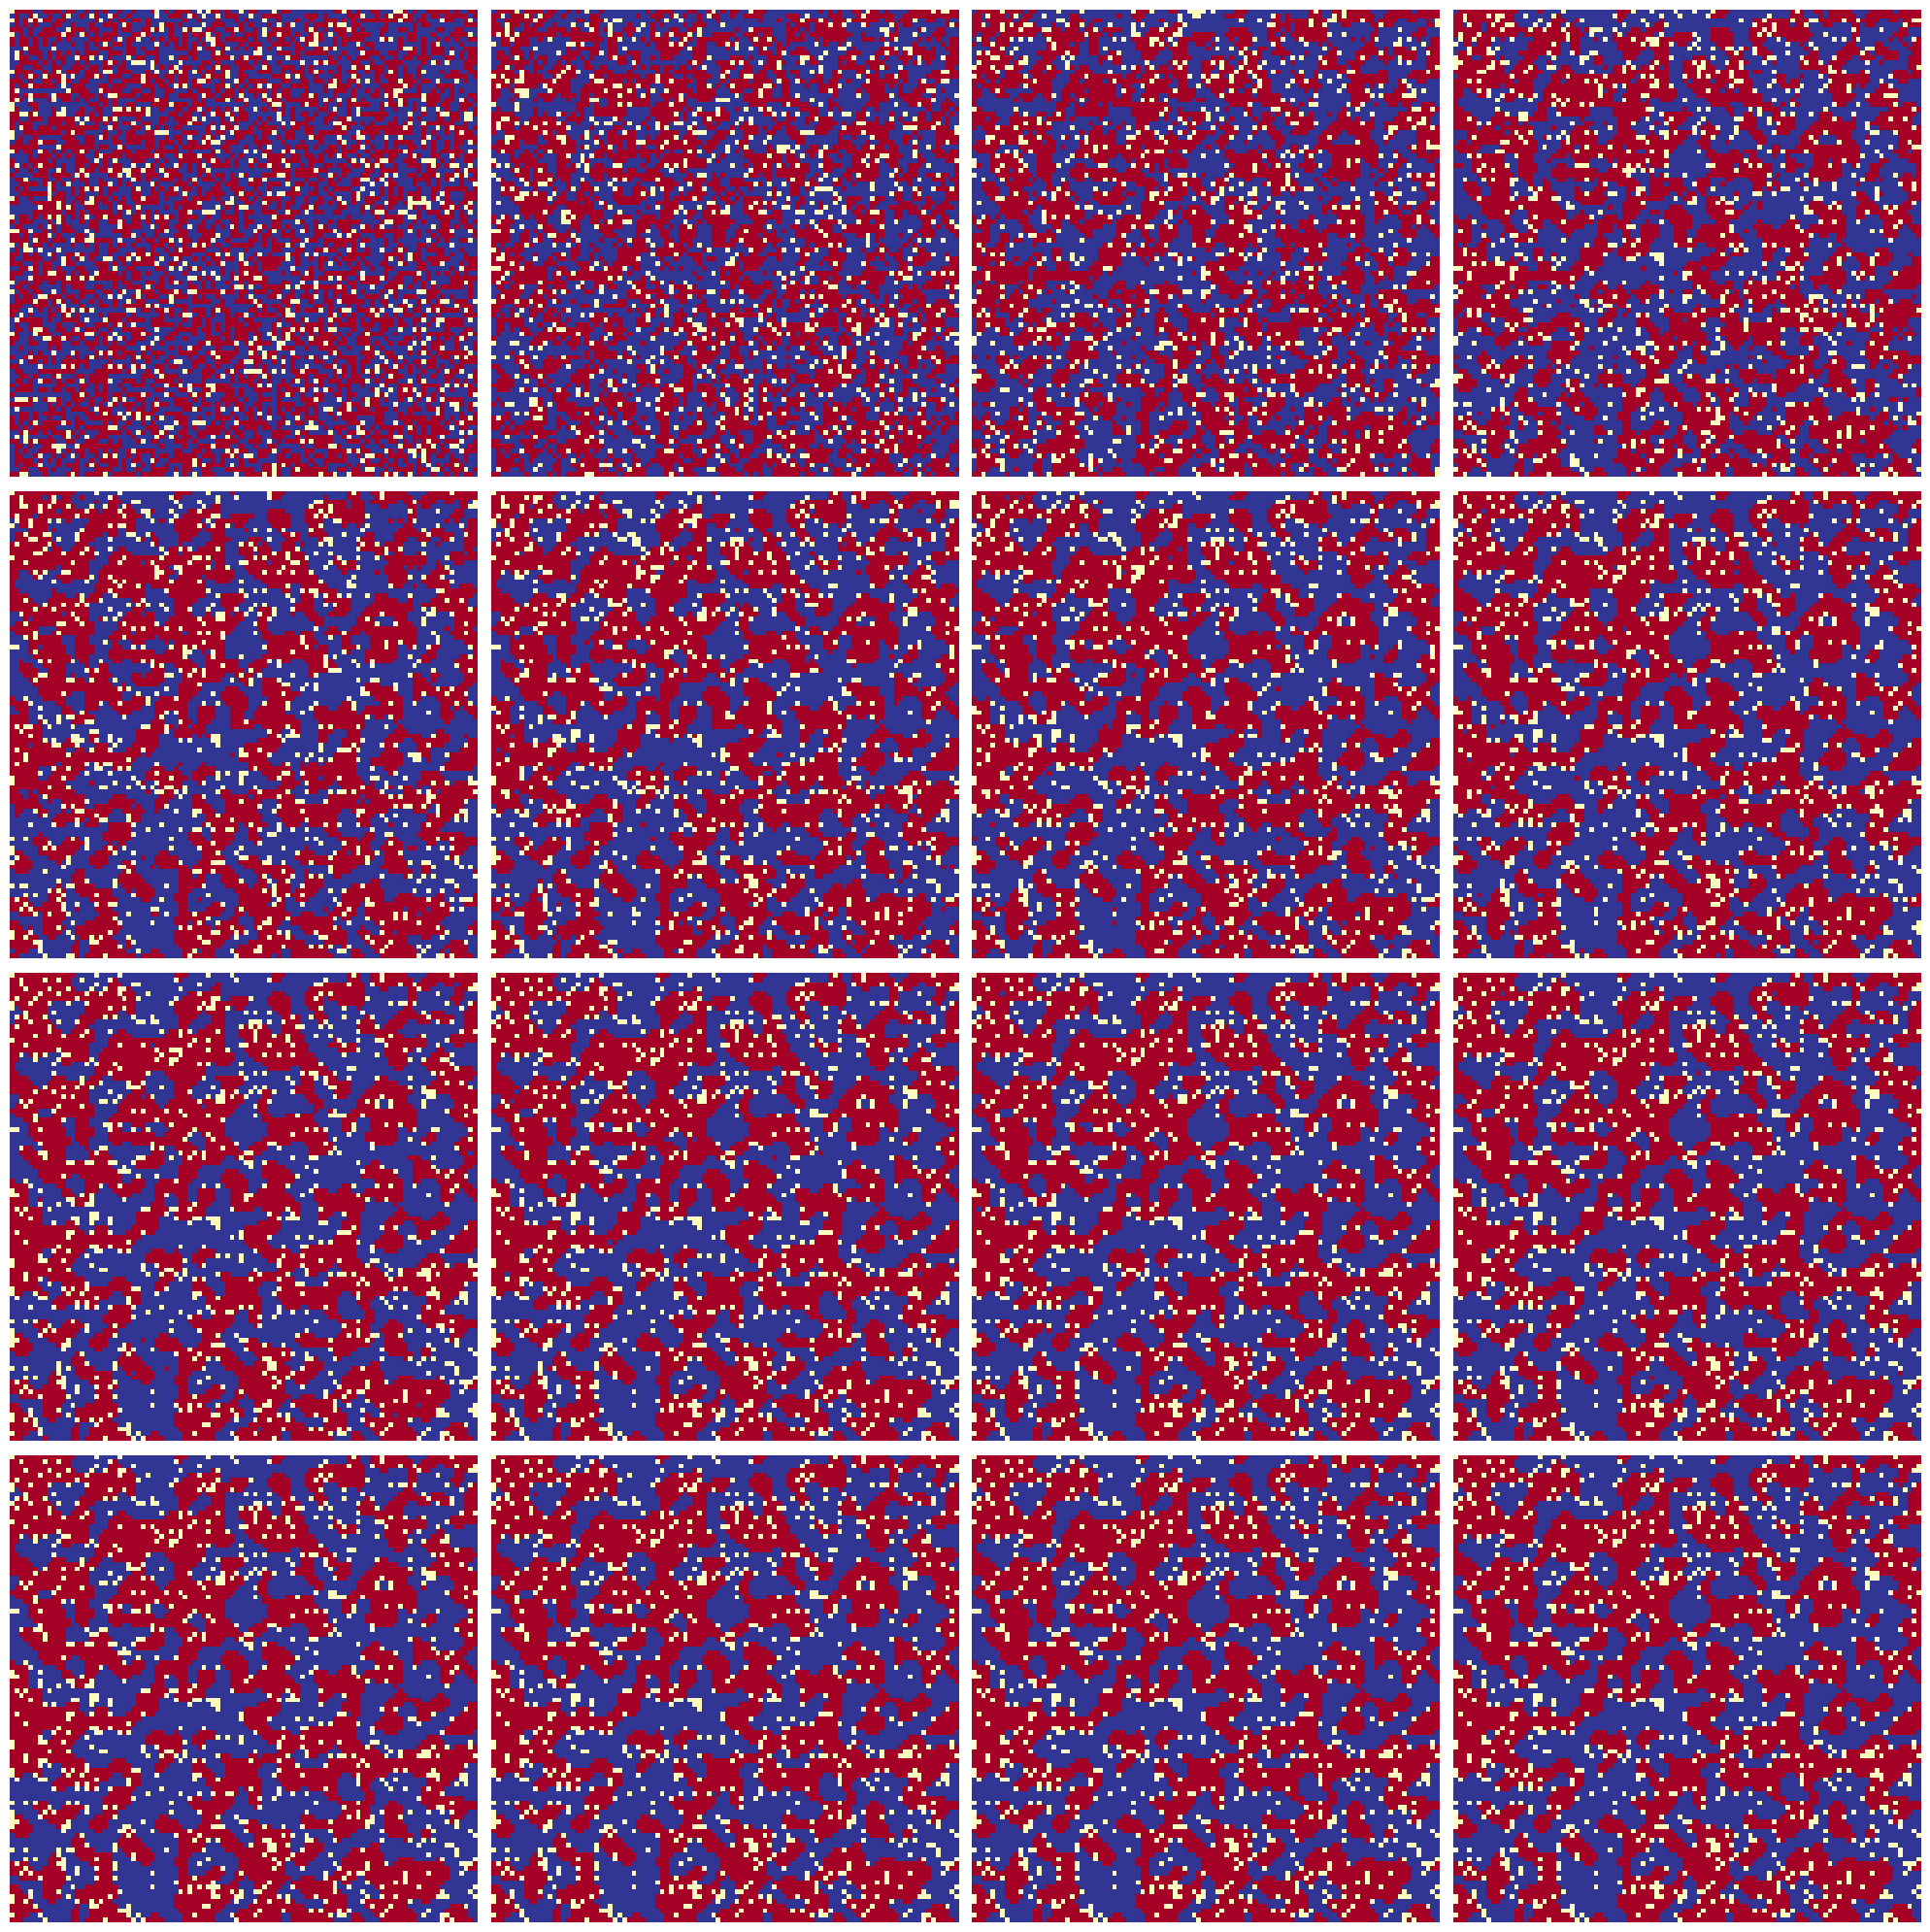

In [57]:
fig, axs = plt.subplots(4, 4, figsize=(20, 20))

axs = axs.ravel()

for i in np.arange(0, len(Schellings_abm.list_feature_grid)):
    axs[i].imshow(Schellings_abm.list_feature_grid[i], cmap="RdYlBu")
    axs[i].set_axis_off()

plt.tight_layout()
plt.show()

# Sensitivity Analysis of the Schelling Model

Let's look at the _spatial dimension_ first. This explores how different tolerance thresholds (`τ`) affect segregation patterns. Here's what's happening step by step:

## The Setup
```python
τ_list = [0.4, 0.5, 0.6, 0.7, 0.8]  # different tolerance levels to test
list_list_mix = []                  # will store complete mixing history for each simulation
get_tau_mix = []                    # will store final mixing value for each tolerance level
```

## The Loop
For each tolerance level τ, the code:

1. Creates a new model instance with that tolerance level (abm(τ=τ, length_grid=100))
2. Initializes it with random agent positions
3.  Runs the simulation until equilibrium
4. Stores the results:

+ Complete mixing history in list_list_mix
+ Final mixing value in get_tau_mix


5. Visualizes the final state:

+ Uses imshow to create a heatmap
+ Red and Blue represent different agent groups
+ Label according to density and tolerance parameters



## Interpretation

+ Lower τ (0.4): Agents are more tolerant of diversity
+ Higher τ (0.8): Agents strongly prefer similar neighbors

The visualizations show how stronger preferences for similarity (higher τ) typically lead to more pronounced segregation patterns. Each plot shows the final equilibrium state for a different tolerance level, allowing us to see how this key parameter affects the emergence of segregation.

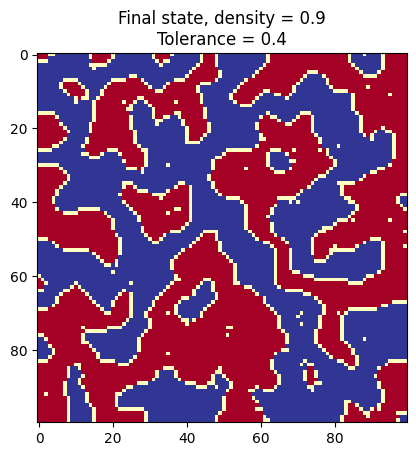

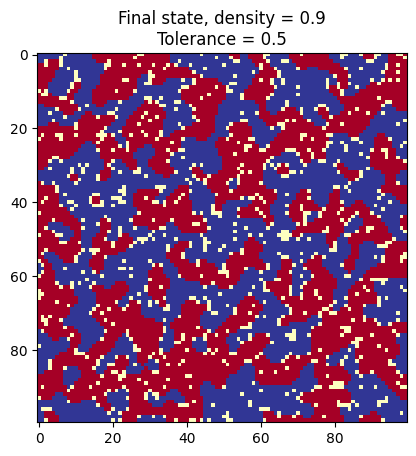

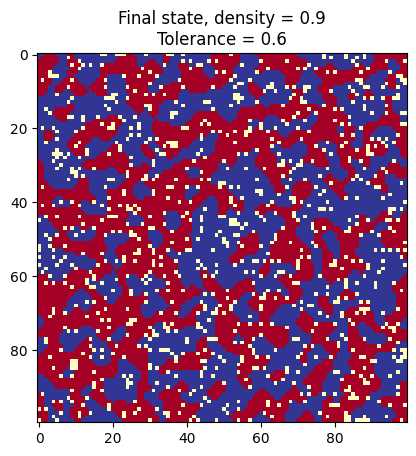

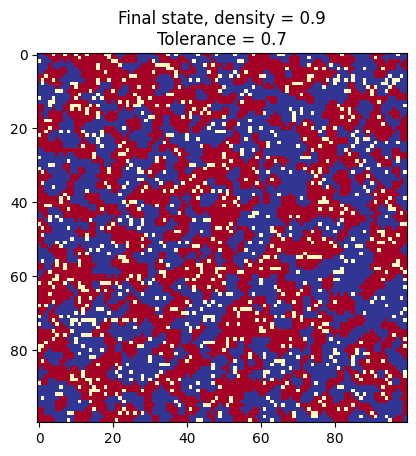

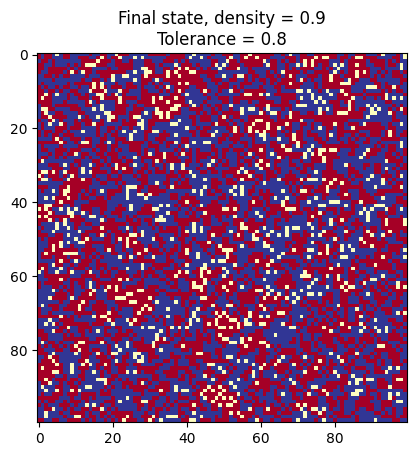

In [24]:
τ_list = [0.4, 0.5, 0.6, 0.7, 0.8]

list_list_mix = []
get_tau_mix = []
for τ in τ_list:
    Schellings_abm = abm(τ=τ, length_grid=100)
    Schellings_abm.initialize()
    Schellings_abm.run()
    list_list_mix.append(Schellings_abm.list_mix)
    get_tau_mix.append(Schellings_abm.list_mix[-1])
    # plt.plot(Schellings_abm.list_mix)
    # plt.show()
    plt.imshow(Schellings_abm.list_feature_grid[-1], cmap="RdYlBu")
    plt.title("Final state, density = "+  str(Schellings_abm.density) +"\nTolerance = " + str(τ))
    plt.show()

# Understanding the Dynamics: Time Evolution of Mixing

Now let's look at the _temporal dimension_: how segregation patterns evolve over time for different tolerance thresholds (τ). Each line here represents a different simulation, where agents have varying levels of tolerance for having different neighbors (from τ=0.4 to 0.8).

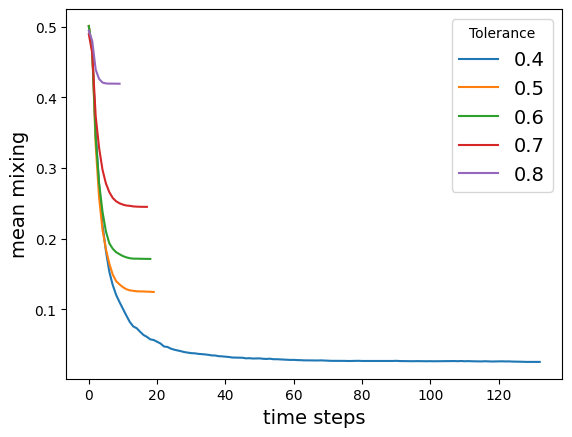

In [25]:
for i, list_m in enumerate(list_list_mix):
    plt.plot(list_m, label=str(τ_list[i]))
plt.legend(fontsize=14, title='Tolerance')
plt.xlabel("time steps", fontsize=14)
plt.ylabel("mean mixing", fontsize=14)
plt.show()

What We See...
- Higher tolerance values (lower τ) generally lead to more mixing (higher values on y-axis)
- Lower tolerance values (higher τ) result in more segregation (lower mixing values)
- All simulations show a rapid initial adjustment period followed by stabilization
- The final equilibrium states are distinctly different for each tolerance level, showing the parameter's strong influence on outcomes


...now let's just remove τ=0.4 because it messes with the scales.

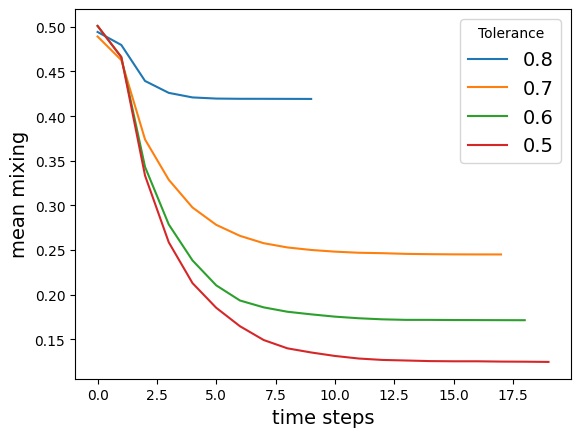

In [26]:
for i, list_m in enumerate(list_list_mix[1:][::-1]):
    plt.plot(list_m, label=str(τ_list[::-1][i]))
plt.legend(fontsize=14, title='Tolerance')
plt.xlabel("time steps", fontsize=14)
plt.ylabel("mean mixing", fontsize=14)
plt.show()

# From ABM to ABC (Approximate Bayesian Computation)

## Why ABC?
In our Schelling model, we observe segregation patterns and mixing levels, but what if we want to work backwards? Given observed segregation patterns in real cities, can we infer the underlying tolerance levels (τ) that might have produced them? This is where Approximate Bayesian Computation comes in - it's a powerful method for parameter estimation when we can simulate our model but can't write down a traditional likelihood function.

```python
# so maybe you have a series of observed states...
mix_index = [
    0.02433994708994693,
    0.1196104497354502,
    0.16866005291005123,
    0.24411481481481234,
    0.43469285714285866
    ]
# ...and you want to figure out what tolerance levels created them.
real_tau_list = [0.4, 0.5, 0.6, 0.7, 0.8]

```

## ABC in Simple Terms
ABC works like a guess-and-check approach:
1. Propose a parameter value (in our case, a tolerance level τ)
2. Simulate the model with that parameter
3. Compare the simulation output to our observed data
4. If they're close enough, keep the parameter value as a possible explanation
5. Repeat many times to build up a distribution of plausible parameters

## Implementation Details

### The Fast Runner
```run_fast()``` is a streamlined version of our simulation that only saves the final state instead of tracking the entire evolution. This is crucial for ABC because we'll be running thousands of simulations - we only care about the final mixing levels we're trying to match.

### The Model Fitter
```fit_model()``` implements our ABC procedure:
- Takes target mixing levels and their known τ values for validation
- Samples potential τ values from a prior distribution (`τ_potential = np.random.uniform(0.3, 0.9, size=trials)`)
- Runs simulations with these proposed values
- Accepts τ values that produce mixing levels close to our targets (`if np.abs(mix_hat - mix_true) < tolerance`)
- Stores accepted values in lists (`τ_accepted[j].append(τ_hat)`)
- Returns distributions of accepted τ values for each target

The key line to focus on is the acceptance criterion: `if np.abs(mix_hat - mix_true) < tolerance`. This implements the core ABC logic - if our simulated mixing level (`mix_hat`) is close enough to our target (`mix_true`), we accept the proposed parameter value.

## A Note on Performance
For the computationally curious: This version uses several algorithmic improvements over the basic implementation. The key optimization is in the `compute_neighbors` method, which uses `scipy.signal.convolve2d` to efficiently calculate all neighborhood relationships at once. Compare:
- Original version: Loops through each agent to check their neighbors
- Optimized version: `convolve2d(feature_grid, kernel, mode='same', boundary='wrap')`
This single line replaces multiple nested loops, making our thousands of ABC simulations feasible.

In [33]:
from scipy.signal import convolve2d

class abm:
    def __init__(self,
                 # length of square grid
                 length_grid=None,
                 # fraction of spots with agents
                 density=None,
                 # possible values of the feature
                 n_features=None,
                 # tolerance threshold for diversity
                 τ=None,
                 # teed for reproducibility
                 seed=123
                 ):

        # set seed
        np.random.seed(seed)

        # set dimensions and parameters
        self.length_grid = length_grid if length_grid is not None else 100
        self.density = density if density is not None else 0.9
        self.n_features = n_features if n_features is not None else 2
        self.τ = τ if τ is not None else 0.6

        # calculate grid size and number of agents
        self.size_grid = self.length_grid * self.length_grid
        self.n_agents = int(self.size_grid * self.density)

        # initialize agents and grid
        self.agents = np.arange(self.n_agents)
        self.grid = np.empty(self.size_grid, dtype=float)
        self.agent_feature = np.zeros(self.n_agents, dtype=int)
        self.agent_positions = np.zeros((self.n_agents, 2), dtype=int)
        self.list_feature_grid = []
        self.list_mix = []

    def initialize(self):
        # build grid with agents and empty spots
        self.grid[:self.n_agents] = self.agents
        self.grid[self.n_agents:] = np.nan
        np.random.shuffle(self.grid)
        self.grid = self.grid.reshape(self.length_grid, self.length_grid)

        # assign features to agents
        self.agent_feature = np.random.choice(self.n_features, size=self.n_agents)

        # map agent IDs to their positions
        occupied_positions = np.argwhere(~np.isnan(self.grid))
        agent_ids_in_grid = self.grid[~np.isnan(self.grid)].astype(int)
        self.agent_positions[agent_ids_in_grid] = occupied_positions

    def make_feature_grid(self):
        # initialize feature grid with zeros (empty spaces)
        feature_grid = np.zeros_like(self.grid)

        # get positions of agents
        agent_mask = ~np.isnan(self.grid)
        agent_ids = self.grid[agent_mask].astype(int)
        features = self.agent_feature[agent_ids]

        # map features 0 to -1, features 1 to +1
        feature_values = np.where(features == 0, -1, 1)
        feature_grid[agent_mask] = feature_values

        return feature_grid

    def compute_neighbors(self):
        # create feature grid
        feature_grid = self.make_feature_grid()

        # create mask for occupied cells
        occupied_mask = feature_grid != 0  # cells that are occupied

        # define convolution kernel to consider 8 neighbors
        kernel = np.ones((3, 3), dtype=int)
        kernel[1, 1] = 0  # exclude the center cell, because you are no important to your own decision to move—it's just your neighbors that matter

        # compute total number of occupied neighbors
        n_occupied_neighbors = convolve2d(occupied_mask.astype(int), kernel, mode='same', boundary='wrap')

        # compute sum of neighbor features
        sum_neighbor_features = convolve2d(feature_grid, kernel, mode='same', boundary='wrap')

        # get own features
        cell_features = feature_grid * occupied_mask  # Zero for empty cells, +/-1 for occupied cells

        # multiply own feature by sum of neighbor features
        product = cell_features * sum_neighbor_features

        # number of same-feature neighbors
        n_same_feature_neighbors = (n_occupied_neighbors + product) / 2
        n_diff_neighbors = n_occupied_neighbors - n_same_feature_neighbors

        # calculate ratio of different neighbors
        with np.errstate(divide='ignore', invalid='ignore'):
            ratio_difference = np.where(n_occupied_neighbors > 0, n_diff_neighbors / n_occupied_neighbors, 1)

        return occupied_mask, ratio_difference

    def agents_move(self):
        occupied_mask, ratio_difference = self.compute_neighbors()

        # compute mix average
        mix_average = np.nanmean(ratio_difference[occupied_mask])

        # identify unhappy agents
        unhappy_mask = (ratio_difference > self.τ) & occupied_mask

        # if no agents are unhappy, return mix_average
        if not np.any(unhappy_mask):
            return mix_average

        # get positions of unhappy agents
        unhappy_positions = np.argwhere(unhappy_mask)

        # find empty positions
        empty_positions = np.argwhere(~occupied_mask)
        np.random.shuffle(empty_positions)
        n_unhappy_agents = len(unhappy_positions)
        n_empty_positions = len(empty_positions)

        # determine the number of moves possible
        num_moves = min(n_unhappy_agents, n_empty_positions)
        if num_moves == 0:
            # no empty positions to move to
            return mix_average

        # select agents and positions for movement
        selected_unhappy_positions = unhappy_positions[:num_moves]
        selected_empty_positions = empty_positions[:num_moves]

        # move agents
        unhappy_agent_ids = self.grid[selected_unhappy_positions[:, 0], selected_unhappy_positions[:, 1]].astype(int)

        # update grid
        self.grid[selected_empty_positions[:, 0], selected_empty_positions[:, 1]] = unhappy_agent_ids
        self.grid[selected_unhappy_positions[:, 0], selected_unhappy_positions[:, 1]] = np.nan

        # update agent_positions
        self.agent_positions[unhappy_agent_ids] = selected_empty_positions

        return mix_average

    def all_agents_happy(self):
        occupied_mask, ratio_difference = self.compute_neighbors()

        # identify unhappy agents
        unhappy_mask = (ratio_difference > self.τ) & occupied_mask

        # find empty positions
        empty_positions = np.argwhere(~occupied_mask)
        if len(empty_positions) == 0:
            # No empty positions, agents cannot move
            return True

        # check if any agent is unhappy
        return not np.any(unhappy_mask)

    def run(self):
        # compute initial mix
        occupied_mask, ratio_difference = self.compute_neighbors()
        initial_mix = np.nanmean(ratio_difference[occupied_mask])

        # add initial state to lists
        self.list_mix.append(initial_mix)
        self.list_feature_grid.append(self.make_feature_grid())

        counter_safety = 0
        # while not all agents are happy, move them
        while not self.all_agents_happy():
            # move agents and calculate mix
            mt = self.agents_move()
            # append mix and feature matrix to lists
            self.list_mix.append(mt)
            self.list_feature_grid.append(self.make_feature_grid())

            # safety check to prevent infinite loops
            counter_safety += 1
            if counter_safety > 1000:
                print("Exceeded maximum iterations.")
                break

    def run_fast(self):
        counter_safety = 0
        # while not all agents are happy, move them
        while not self.all_agents_happy():
            # move agents
            mt = self.agents_move()
            counter_safety += 1
            if counter_safety > 500:
                # print("Exceeded maximum iterations.")
                mt = np.nan
                break
        # only save last step
        self.list_mix.append(mt)
        self.list_feature_grid.append(self.make_feature_grid())

def fit_model(mix_list, tau_list, tolerance=0.01, trials=100):
    assert len(mix_list) == len(tau_list)
    # generate potential τ values from a uniform prior
    τ_potential = np.random.uniform(0.3, 0.9, size=trials)
    # initialize list to store accepted τ values for each target τ
    τ_accepted = [[] for _ in range(len(tau_list))]

    # iterate over potential τ samples
    for i, τ_hat in enumerate(τ_potential):
        # run the model with the proposed τ_hat
        model = abm(τ=τ_hat)
        model.initialize()
        model.run_fast()
        mix_hat = model.list_mix[-1]

        # check whether the resulting mix_hat is within tolerance for each target τ
        for j, (τ_true, mix_true) in enumerate(zip(tau_list, mix_list)):
            if np.abs(mix_hat - mix_true) < tolerance:
                τ_accepted[j].append(τ_hat)
                # print(f"Accepted τ_hat: {τ_hat} for τ_true: {τ_true} with mix_hat: {mix_hat}")

        if i % 10 == 0:
            print(f"Completed iteration {i}/{trials}")

    return τ_accepted

# Running the ABC Analysis: What Happens Under the Hood

When we execute this code block, here's the sequence that will unfold:

1. We start with real-world (or in this case, simulated) data:
  - 5 observed mixing levels (from very mixed 0.43 to very segregated 0.024)
  - Their corresponding known tolerance values (τ from 0.4 to 0.8)
  - These serve as our "ground truth" to validate our ABC approach

2. For each of the 1000 trials:
  - Draw a random tolerance value between 0.3 and 0.9
  - Create a fresh Schelling model with this proposed τ
  - Run it until equilibrium (or max iterations)
  - Record the final mixing level

3. For each proposed τ and resulting mixing level:
  - Compare against _all five_ of our target mixing levels
  - If within 0.01 (our tolerance) of any target:
     - Store this τ as a possible explanation for that mixing level
  - One proposed τ might explain multiple mixing levels, or none

4. At the end, for each of our five target mixing levels:
  - We'll have a collection of τ values that could have produced that pattern
  - These collections form our posterior distributions
  - The better our ABC worked, the more these distributions should center around our known "true" values

The `%time` at the start will tell us how long this whole process took - with 1000 trials and 5 targets, we're effectively running 5000 comparisons!

In [30]:
# define mix indices and corresponding real τ values
mix_index = [
    0.02433994708994693,
    0.1196104497354502,
    0.16866005291005123,
    0.24411481481481234,
    0.43469285714285866
    ]

real_tau_list = [0.4, 0.5, 0.6, 0.7, 0.8]

# run the fit_model function
%time τ_accepted = fit_model(mix_index, real_tau_list, tolerance=0.01, trials=1000)

Completed iteration 0/1000
Completed iteration 10/1000
Completed iteration 20/1000
Completed iteration 30/1000
Completed iteration 40/1000
Completed iteration 50/1000
Completed iteration 60/1000
Completed iteration 70/1000
Completed iteration 80/1000
Completed iteration 90/1000
Completed iteration 100/1000
Completed iteration 110/1000
Completed iteration 120/1000
Completed iteration 130/1000
Completed iteration 140/1000
Completed iteration 150/1000
Completed iteration 160/1000
Completed iteration 170/1000
Completed iteration 180/1000
Completed iteration 190/1000
Completed iteration 200/1000
Completed iteration 210/1000
Completed iteration 220/1000
Completed iteration 230/1000
Completed iteration 240/1000
Completed iteration 250/1000
Completed iteration 260/1000
Completed iteration 270/1000
Completed iteration 280/1000
Completed iteration 290/1000
Completed iteration 300/1000
Completed iteration 310/1000
Completed iteration 320/1000
Completed iteration 330/1000
Completed iteration 340/1

# Interpreting the ABC Results

Let's show how well our ABC method recovered the true tolerance parameters:

## What We're Looking At
- Each histogram shows accepted τ values for a different target mixing level
- Red vertical lines show the true τ values we're trying to recover
- Dashed black lines show the mean of our ABC-accepted values
- The x-axis spans our prior range (0.3 to 0.9)

## What Makes for Good Results?
1. **Centered Distributions**: The histograms should peak near their corresponding red lines (true values)
2. **Narrow Distributions**: Tighter histograms mean more precise parameter estimates
3. **Separation**: Different mixing levels should produce distinct distributions
4. **Coverage**: The dashed lines (ABC means) should closely align with the red lines (true values)

## What We Learn
This type of plot helps us understand:
- How well we can infer underlying preferences from observed patterns
- Where our inference is more/less precise
- Whether certain tolerance levels are harder to distinguish
- If our ABC approach is working as intended (by comparing to known true values)

The beauty of ABC is that even though we can't write down exactly how τ maps to mixing levels, we can still recover these relationships through simulation!

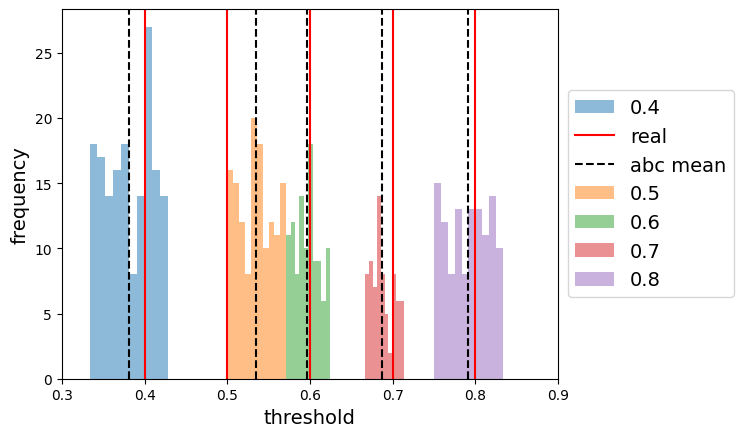

In [31]:
fig = plt.figure()
ax = plt.subplot(111)

for i, t_acc in enumerate(τ_accepted):
    ax.hist(τ_accepted[i], alpha=0.5, label=str(real_tau_list[i]))
    if i == 0:
        ax.axvline(x=real_tau_list[i], color="red", label="real")
        ax.axvline(x=np.mean(τ_accepted[i]), linestyle="--", color="k", label="abc mean")
    else:
        ax.axvline(x=real_tau_list[i], color="red")
        ax.axvline(x=np.mean(τ_accepted[i]), linestyle="--", color="k")

ax.legend(loc='center left', bbox_to_anchor=(1, 0.5), fontsize=14)
plt.xlim([0.3, 0.9])
plt.xlabel("threshold", fontsize=14)
plt.ylabel("frequency", fontsize=14)
plt.show()

# How did it do?

(For those still interested in agent-based models, the `mesa` package in Python is a popular way to build them.)